# Deep neural networks: Homework task 1
# Task implementation
##### Author: Mikołaj Mazurczyk
##### Index no: 426819

---

# Downloading the data


In [1]:
!wget https://www.mimuw.edu.pl/~ciebie/gsn-2021-1.zip
!unzip gsn-2021-1.zip &> /dev/null
#!rm -r data
!rm gsn-2021-1.zip

--2021-05-04 18:52:35--  https://www.mimuw.edu.pl/~ciebie/gsn-2021-1.zip
Resolving www.mimuw.edu.pl (www.mimuw.edu.pl)... 193.0.96.14
Connecting to www.mimuw.edu.pl (www.mimuw.edu.pl)|193.0.96.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘gsn-2021-1.zip’

gsn-2021-1.zip      100%[===================>]   5.29M  3.78MB/s    in 1.4s    

2021-05-04 18:52:37 (3.78 MB/s) - ‘gsn-2021-1.zip’ saved [5544261/5544261]



# Dataset

In [2]:
from torch.utils.data import Dataset
import torch
import os
from PIL import Image
import numpy as np


class GeometricShapesDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('1')

        shape_classes = np.array(self.data_frame.iloc[idx, 1:]).astype('float')
        sample = {'image': image, 'shape_classes': shape_classes}

        if self.transform:
            sample = self.transform(sample)

        return sample


# Auguemntations

In [3]:
from matplotlib import pyplot


UP_IDX = 2
RIGHT_IDX = 3
DOWN_IDX = 4
LEFT_IDX = 5

    
class Rotate90(object):
    def shift_values(self, arr, start_pos):
        arr_len = len(arr)
        assert(start_pos < arr_len - 1)
        tmp = arr[start_pos]
        idx = start_pos
        while (idx < arr_len - 1):
            arr[idx] = arr[idx + 1]
            idx += 1
    
        arr[idx] = tmp

    def __init__(self):
        pass

    def __call__(self, sample):
        image, shape_classes = sample['image'], sample['shape_classes']
        new_img = image.rotate(90)
        new_shape_classes = np.copy(shape_classes)
        self.shift_values(new_shape_classes, 2)

        return {'image': new_img, 'shape_classes': new_shape_classes}


def swap_values(arr, x, y):
    tmp = arr[x]
    arr[x] = arr[y]
    arr[y] = tmp


class HorizontalFlip(object):
    def __init__(self):
        pass

    def __call__(self, sample):
        image, shape_classes = sample['image'], sample['shape_classes']
        new_img = image.transpose(Image.FLIP_TOP_BOTTOM)
        new_shape_classes = np.copy(shape_classes)
        swap_values(new_shape_classes, UP_IDX, DOWN_IDX)

        return {'image': new_img, 'shape_classes': new_shape_classes}


class VerticalFlip(object):
    def __init__(self):
        pass

    def __call__(self, sample):
        image, shape_classes = sample['image'], sample['shape_classes']
        new_img = image.transpose(Image.FLIP_LEFT_RIGHT)
        new_shape_classes = np.copy(shape_classes)
        swap_values(shape_classes, LEFT_IDX, RIGHT_IDX)

        return {'image': new_img, 'shape_classes': new_shape_classes}

class ToTensor(object):
    def __call__(self, sample):
        image, shape_classes = sample['image'], sample['shape_classes']
        image = np.asarray(image).reshape((1, 28, 28)).astype('float')

        return {'image': torch.from_numpy(image),
                'shape_classes': torch.from_numpy(shape_classes)}


# Shape classification network

In [70]:
import torch.nn as nn


def features_num(x):
    sizes = x.size()[1:]
    res = 1
    for size in sizes:
        res *= size
    return res


class ShapeClassificationNet(nn.Module):
    def __init__(self):
        super(ShapeClassificationNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, 
                      kernel_size=(5, 5), padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=(5, 5), padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=(5, 5), padding=(2, 2)),
            nn.ReLU()
        )
        self.lin = nn.Sequential(
            nn.Linear(7*7*128, 7*128),
            nn.ReLU(),
            nn.Linear(7*128, 128),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, features_num(x))
        x = self.lin(x)
        return x


# Shape classification additional metric

In [5]:
def convert_labels(labels):
    labels[labels != 0.] = 1.


# Shape classification trainer

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torchvision
import torchvision.transforms as transforms



def get_two_max_idx(arr):
    a = 0.
    b = 0.
    a_i = 0
    b_i = 0
    for i in range(6):
        if arr[i] > a:
            b = a
            b_i = a_i
            a = arr[i]
            a_i = i
        elif arr[i] > b:
            b = arr[i]
            b_i = i
    
    if a_i < b_i:
        return a_i, b_i
    else:
        return b_i, a_i

class ShapeClassificationTrainer(object):
    def __init__(self, trainset, testset, net, train_batch=100, epochs=20):
        use_cuda = torch.cuda.is_available()
        print(f"Use cuda: {use_cuda}")
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.trainset = trainset
        self.trainloader = torch.utils.data.DataLoader(
            self.trainset, batch_size=train_batch, shuffle=True, num_workers=2,
            pin_memory=True)
        self.testset = testset
        self.testloader = torch.utils.data.DataLoader(
            self.testset, batch_size=1, shuffle=False, num_workers=2, 
            pin_memory=True)
        self.net = net
        self.epochs = epochs

    def train(self):
        losses = []
        accuracies = []
        epochs = []
        self.net = self.net.to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.SGD(self.net.parameters(), lr=0.05, momentum=0.9)
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            c = 0
            for i, data in enumerate(self.trainloader, 0):
                img_key, label_key = data
                images, labels = data[img_key], data[label_key]
                images = images.to(device=self.device, dtype=torch.float)
                convert_labels(labels)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                predicted_probas = self.net(images)
                loss = criterion(predicted_probas.float(), labels.float())
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                c += 1
            epoch_loss = epoch_loss / c
            print(f"Epoch: {epoch}")
            print(f"Loss: {epoch_loss}")

            correct = 0
            total = 0
            with torch.no_grad():
                for data in self.testloader:
                    img_key, label_key = data
                    images, labels = data[img_key], data[label_key]
                    images = images.to(device=self.device, dtype=torch.float)
                    convert_labels(labels)
                    labels = labels.to(self.device)
                    predicted_probas = self.net(images)

                    (i, j) = get_two_max_idx(predicted_probas[0])
                    total += 1
                    correct += (labels[0][i] == 1. and labels[0][j] == 1.)
            accuracy = 100 * correct / total 
            print(f"Accuracy on testset: {accuracy}%")
            print("-" * 45)
            accuracies.append(accuracy)
            losses.append(epoch_loss)
            epochs.append(epoch + 1)
        return losses, accuracies, epochs

    def get_classification(self, i, j):
        classes = ["squares", "circles", "up", "right", "down", "left"]
        return classes[i] + " : " + classes[j]

    def get_confusion_matrix(self):
        actual = []
        predicted = []
        with torch.no_grad():
            for data in self.testloader:
                img_key, label_key = data
                images, labels = data[img_key], data[label_key]
                images = images.to(device=self.device, dtype=torch.float)
                convert_labels(labels)
                labels = labels.to(self.device)
                predicted_probas = self.net(images)
                a, b = get_two_max_idx(predicted_probas[0])
                c, d = get_two_max_idx(labels[0])
                actual.append(self.get_classification(c, d))
                predicted.append(self.get_classification(a, b))
        
        return actual, predicted

            
            


# Shape classification network results


---
### Preparing dataset


In [60]:
import pandas as pd

data = pd.read_csv("data/labels.csv")
train_data_frame = data.head(9000).copy()
test_data_frame = data.tail(1000).copy().reset_index(drop=True)

rotate180 = transforms.Compose([Rotate90(), Rotate90()])
rotate270 = transforms.Compose([Rotate90(), Rotate90(), Rotate90()])
train_transform = transforms.Compose([transforms.RandomChoice([Rotate90(), 
                                                               rotate180, 
                                                               rotate270, 
                                                               HorizontalFlip(), 
                                                               VerticalFlip(),
                                                               transforms.Lambda(lambda x: x)]),
                                      ToTensor()])
test_transform = transforms.Compose([ToTensor()])

trainset = GeometricShapesDataset(data_frame=train_data_frame, root_dir='data/',
                                  transform=train_transform)

testset = GeometricShapesDataset(data_frame=test_data_frame, root_dir='data/',
                                 transform=test_transform)

### Training the shape classification network

In [71]:
sc_trainer = ShapeClassificationTrainer(
    trainset, testset, ShapeClassificationNet(), epochs=25)
losses, accuracies, epochs = sc_trainer.train()

Use cuda: True
Epoch: 0
Loss: 0.7187332623534732
Accuracy on testset: 6.600000381469727%
---------------------------------------------
Epoch: 1
Loss: 0.7184620208210415
Accuracy on testset: 7.800000190734863%
---------------------------------------------
Epoch: 2
Loss: 0.7169886151949565
Accuracy on testset: 12.300000190734863%
---------------------------------------------
Epoch: 3
Loss: 0.6967992113696204
Accuracy on testset: 17.200000762939453%
---------------------------------------------
Epoch: 4
Loss: 0.6404750446478525
Accuracy on testset: 22.000001907348633%
---------------------------------------------
Epoch: 5
Loss: 0.6036047604348924
Accuracy on testset: 27.700000762939453%
---------------------------------------------
Epoch: 6
Loss: 0.5816385408242544
Accuracy on testset: 33.0%
---------------------------------------------
Epoch: 7
Loss: 0.5210864285628001
Accuracy on testset: 48.70000076293945%
---------------------------------------------
Epoch: 8
Loss: 0.4726235141356786


### Results plot

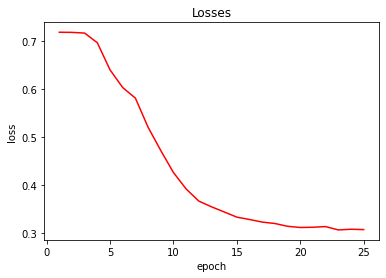

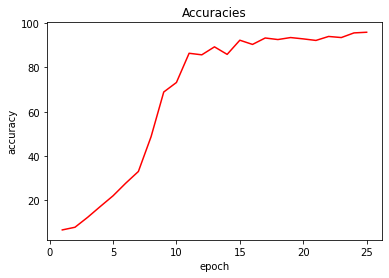

In [72]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title("Losses")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.plot(epochs, losses, color="red")
fig1.savefig("losses.eps", format='eps')

fig2, ax2 = plt.subplots()
ax2.set_title("Accuracies")
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.plot(epochs, accuracies, color="red")
fig2.savefig("accuracies.eps", format='eps')

### Confusion matrix

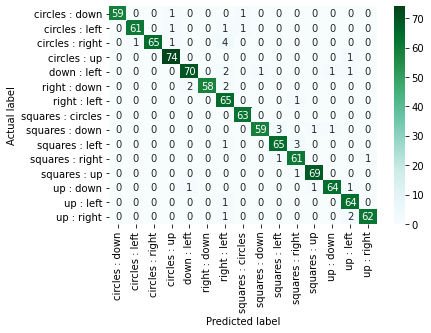

In [73]:
import seaborn as sn
plt.tight_layout()
actual, predicted = sc_trainer.get_confusion_matrix()
data = {"actual":    actual, "predicted": predicted}

df = pd.DataFrame(data, columns=["actual","predicted"])
confusion_matrix = pd.crosstab(df["actual"], df["predicted"], 
                               rownames=["Actual label"], 
                               colnames=["Predicted label"])

sn.heatmap(confusion_matrix, annot=True, cmap="BuGn")
plt.savefig("confusion-matrix.eps", format='eps', bbox_inches='tight')
plt.show()